# Libraries

In [1]:
! pip install timm
! pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 975.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=a63c9e73a7489e4413baaa2df86891560fc3754ee8a0b9b78876737796293a1a
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=c40b66dafab22c65757c9a9fe44f67e503c257fb65da2b5acf72663208590624
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built effici

In [2]:
import os
import gc
import time
import random


import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import timm

from sklearn.model_selection import StratifiedGroupKFold

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda import amp

import segmentation_models_pytorch as smp

import albumentations as A
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings("ignore")

# Configuration

In [3]:
class CFG:
    seed          = 42
    debug         = False
    exp_name      = 'Baseline'
    comment       = 'unet-efficientnet_b1-224x224-aug2-split2'
    model_name    = 'Unet'
    backbone      = 'efficientnet-b1'
    batch_size    = 128
    img_size      = [224, 224]
    epochs        = 15
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/batch_size*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 32//batch_size)
    n_fold        = 5
    num_classes   = 3
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(CFG.seed)

# Meta Data

In [5]:
df = pd.read_csv('../input/uwmgi-mask-dataset/train.csv')

df['segmentation'] = df.segmentation.fillna('')
df['rle_len'] = df.segmentation.map(len)
df['mask_path'] = df.mask_path.str.replace('/png/','/np').str.replace('.png','.npy')

In [6]:
df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index()
df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index())

df = df.drop(columns=['segmentation', 'class', 'rle_len'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df['empty'] = (df.rle_len==0)

In [7]:
df.head()

,id,case,day,slice,image_path,height,width,mask_path,segmentation,rle_len,empty
0,case123_day20_slice_0001,123,20,1,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...,"[, , ]",0,True
1,case123_day20_slice_0002,123,20,2,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...,"[, , ]",0,True
2,case123_day20_slice_0003,123,20,3,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...,"[, , ]",0,True
3,case123_day20_slice_0004,123,20,4,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...,"[, , ]",0,True
4,case123_day20_slice_0005,123,20,5,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...,"[, , ]",0,True


# Utilities

In [8]:
#https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [9]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
    img = img.astype('float32') # original is uint16
    mx = np.max(img)
    if mx:
        img/=mx # scale image to [0, 1]
    return img

def load_msk(path):
    msk = np.load(path)
    msk = msk.astype('float32')
    msk/=255.0
    return msk

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

# Dataset

In [11]:
class BuildDataset(Dataset):
    def __init__(self, df, label=True, transforms=None):
        self.df         = df
        self.label      = label
        self.img_paths  = df['image_path'].tolist()
        self.msk_paths  = df['mask_path'].tolist()
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_path  = self.img_paths[index]
        img = []
        img = load_img(img_path)
        
        if self.label:
            msk_path = self.msk_paths[index]
            msk = load_msk(msk_path)
            if self.transforms:
                data = self.transforms(image=img, mask=msk)
                img  = data['image']
                msk  = data['mask']
            img = np.transpose(img, (2, 0, 1))
            msk = np.transpose(msk, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img  = data['image']
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img)

# Transformations

In [12]:
data_transforms = {
    "train": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            #A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
        A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                        min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    
    "valid": A.Compose([
        A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

# K-fold

In [13]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['empty'], groups = df["case"])):
    df.loc[val_idx, 'fold'] = fold
df.groupby(['fold','empty'])['id'].count()

fold  empty
0.0   False    4007
      True     4857
1.0   False    3945
      True     4951
2.0   False    2788
      True     3692
3.0   False    2936
      True     4232
4.0   False    2914
      True     4174
Name: id, dtype: int64

# Data Loader

In [14]:
def prepare_loaders(fold):
    train_df = df[df['fold'] != fold].reset_index(drop=True)
    valid_df = df[df['fold'] == fold].reset_index(drop=True)
    
    if CFG.debug:
        train_df = train_df[train_df['empty'] == False].head(160)
        valid_df = valid_df[valid_df['empty'] == False].head(100)
        
    train_dataset = BuildDataset(train_df, transforms=data_transforms['train'])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms['valid'])
    
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size if not CFG.debug else 20,
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size*2 if not CFG.debug else 20,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [15]:
train_loader, valid_loader = prepare_loaders(fold=4)

In [16]:
imgs, msks = next(iter(train_loader))

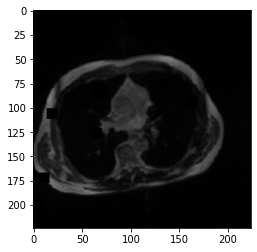

In [17]:
plt.imshow(imgs[0].permute((1, 2, 0)))
plt.imshow(msks[0].permute((1, 2, 0)), alpha=0.5)

In [18]:
def plot_batch(imgs, msks, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx,].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx,].permute((1, 2, 0)).numpy()*255.0
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

In [19]:
from matplotlib.patches import Rectangle

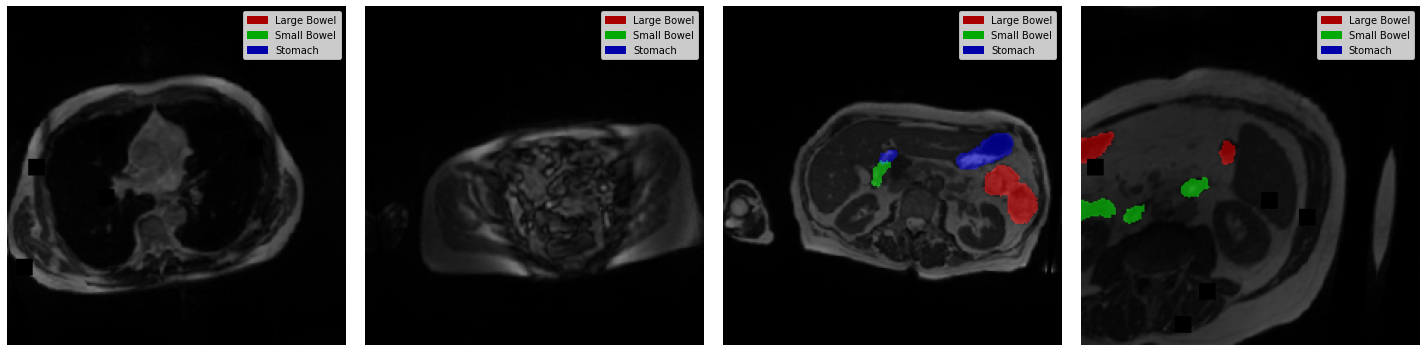

In [20]:
plot_batch(imgs, msks, 4)

# Model

In [21]:
def build_model():
    model = smp.Unet(
        encoder_name=CFG.backbone,
        encoder_weights="imagenet",
        in_channels=3,
        classes=CFG.num_classes,
        activation=None,
    )

    model.to(CFG.device)
    return model

In [22]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

In [23]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

In [24]:
def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

# Training

In [25]:
def train_fn(model, dataloader, criterion, optimizer, scheduler, epoch, device):
    
    model.train()
    scaler = amp.GradScaler()
    
    losses = AverageMeter()
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    for step, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss   = criterion(y_pred, masks)
        
        losses.update(loss.item(), batch_size)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        
        scheduler.step()
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{losses.avg:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
        
    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg

In [26]:
@torch.no_grad()
def valid_fn(model, dataloader, criterion, epoch, device):
    
    model.eval()
    
    losses = AverageMeter()
    dice_coefs = AverageMeter()
    iou_coefs = AverageMeter()
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
    for step, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        y_pred  = model(images)
        loss    = criterion(y_pred, masks)
        
        losses.update(loss.item(), batch_size)
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        dice_coefs.update(val_dice, batch_size)
        iou_coefs.update(val_jaccard, batch_size)
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{losses.avg:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    
    
    torch.cuda.empty_cache()
    gc.collect()
    
    return losses.avg, dice_coefs.avg, iou_coefs.avg
    

In [27]:
def train_loop(model, train_loader, valid_loader, criterion, optimizer, scheduler, epochs):
    
    history = {'Train Loss':[], 'Valid Loss':[], 'Valid Dice':[], 'Valid Jaccard':[]}
    start = time.time()
    
    best_score = -np.inf
    for epoch in range(epochs):
        gc.collect()
        torch.cuda.empty_cache()
        
        train_loss = train_fn(model, train_loader, criterion, optimizer, scheduler, epoch, CFG.device)
        val_loss, val_dice, val_jaccard = valid_fn(model, valid_loader, criterion, epoch, CFG.device)
        
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        
        print(f'Epoch {epoch + 1}', end = ": ")
        print(f'Train Loss: {train_loss:.4f} | Valid Loss: {val_loss:.4f} | Dice: {val_dice:0.4f} | Jaccard: {val_jaccard:0.4f}')
        
        if val_dice >= best_score:
            print(f'Score Improved {best_score:.4f} ---> {val_dice:.4f}')
            best_score = val_dice
            torch.save(model.state_dict(), "best_model_4.pt")
            
    end = time.time()
    time_elapsed = end - start
    
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    

In [28]:
model = build_model()
optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr)
train_loader, valid_loader = prepare_loaders(fold=4)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth


  0%|          | 0.00/30.1M [00:00<?, ?B/s]

In [29]:
train_loop(model, train_loader, valid_loader, criterion, optimizer, scheduler, CFG.epochs)

Valid : 100%|██████████| 28/28 [01:10<00:00,  2.54s/it, gpu_memory=9.17 GB, lr=0.00198, valid_loss=0.3539]


Epoch 1: Train Loss: 0.3556 | Valid Loss: 0.3539 | Dice: 0.7045 | Jaccard: 0.6780
Score Improved -inf ---> 0.7045


Valid : 100%|██████████| 28/28 [01:10<00:00,  2.52s/it, gpu_memory=9.17 GB, lr=0.00191, valid_loss=0.2838]


Epoch 2: Train Loss: 0.1670 | Valid Loss: 0.2838 | Dice: 0.6387 | Jaccard: 0.6058


Valid : 100%|██████████| 28/28 [01:11<00:00,  2.56s/it, gpu_memory=9.17 GB, lr=0.00180, valid_loss=0.1701]


Epoch 3: Train Loss: 0.1299 | Valid Loss: 0.1701 | Dice: 0.8524 | Jaccard: 0.8221
Score Improved 0.7045 ---> 0.8524


Valid : 100%|██████████| 28/28 [01:13<00:00,  2.61s/it, gpu_memory=9.17 GB, lr=0.00165, valid_loss=0.1543]


Epoch 4: Train Loss: 0.1205 | Valid Loss: 0.1543 | Dice: 0.8724 | Jaccard: 0.8431
Score Improved 0.8524 ---> 0.8724


Valid : 100%|██████████| 28/28 [01:12<00:00,  2.57s/it, gpu_memory=9.17 GB, lr=0.00147, valid_loss=0.1473]


Epoch 5: Train Loss: 0.1103 | Valid Loss: 0.1473 | Dice: 0.8813 | Jaccard: 0.8518
Score Improved 0.8724 ---> 0.8813


Valid : 100%|██████████| 28/28 [01:11<00:00,  2.56s/it, gpu_memory=9.17 GB, lr=0.00127, valid_loss=0.1496]


Epoch 6: Train Loss: 0.1066 | Valid Loss: 0.1496 | Dice: 0.8743 | Jaccard: 0.8446


Valid : 100%|██████████| 28/28 [01:10<00:00,  2.52s/it, gpu_memory=9.17 GB, lr=0.00105, valid_loss=0.1352]


Epoch 7: Train Loss: 0.1009 | Valid Loss: 0.1352 | Dice: 0.8906 | Jaccard: 0.8616
Score Improved 0.8813 ---> 0.8906


Valid : 100%|██████████| 28/28 [01:12<00:00,  2.59s/it, gpu_memory=9.17 GB, lr=0.00084, valid_loss=0.1404]


Epoch 8: Train Loss: 0.0960 | Valid Loss: 0.1404 | Dice: 0.8918 | Jaccard: 0.8632
Score Improved 0.8906 ---> 0.8918


Valid : 100%|██████████| 28/28 [01:11<00:00,  2.56s/it, gpu_memory=9.17 GB, lr=0.00063, valid_loss=0.1337]


Epoch 9: Train Loss: 0.0917 | Valid Loss: 0.1337 | Dice: 0.8930 | Jaccard: 0.8644
Score Improved 0.8918 ---> 0.8930


Valid : 100%|██████████| 28/28 [01:12<00:00,  2.60s/it, gpu_memory=9.17 GB, lr=0.00044, valid_loss=0.1323]


Epoch 10: Train Loss: 0.0871 | Valid Loss: 0.1323 | Dice: 0.8942 | Jaccard: 0.8652
Score Improved 0.8930 ---> 0.8942


Valid : 100%|██████████| 28/28 [01:12<00:00,  2.60s/it, gpu_memory=9.17 GB, lr=0.00027, valid_loss=0.1272]


Epoch 11: Train Loss: 0.0846 | Valid Loss: 0.1272 | Dice: 0.8984 | Jaccard: 0.8700
Score Improved 0.8942 ---> 0.8984


Valid : 100%|██████████| 28/28 [01:12<00:00,  2.59s/it, gpu_memory=9.17 GB, lr=0.00014, valid_loss=0.1281]


Epoch 12: Train Loss: 0.0814 | Valid Loss: 0.1281 | Dice: 0.8999 | Jaccard: 0.8717
Score Improved 0.8984 ---> 0.8999


Valid : 100%|██████████| 28/28 [01:12<00:00,  2.60s/it, gpu_memory=9.17 GB, lr=0.00005, valid_loss=0.1273]


Epoch 13: Train Loss: 0.0801 | Valid Loss: 0.1273 | Dice: 0.9019 | Jaccard: 0.8738
Score Improved 0.8999 ---> 0.9019


Valid : 100%|██████████| 28/28 [01:12<00:00,  2.60s/it, gpu_memory=9.17 GB, lr=0.00001, valid_loss=0.1284]


Epoch 14: Train Loss: 0.0787 | Valid Loss: 0.1284 | Dice: 0.9007 | Jaccard: 0.8727


Valid : 100%|██████████| 28/28 [01:14<00:00,  2.65s/it, gpu_memory=9.17 GB, lr=0.00001, valid_loss=0.1281]


Epoch 15: Train Loss: 0.0783 | Valid Loss: 0.1281 | Dice: 0.9008 | Jaccard: 0.8728
Training complete in 3h 5m 59s
